<a href="https://colab.research.google.com/github/NMashalov/2023-DGM-MIPT-course/blob/main/homeworks/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework6: Denoising Diffusion generative models

## Task 1: Theory (4pt)

### Problem 1: KFP theorem (2pt)

In Lecture 10 we have faced with 2 different formulations of Kolmogorov-Fokker-Planck theorem.

1) We used the following KFP theorem when we discussed continuous-in-time NF:
$$
\frac{d \log p(\mathbf{x}(t), t)}{d t} = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right).
$$

2) We used the following KFP theorem when we discussed SDEs:
$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = \text{tr}\left(- \frac{\partial}{\partial \mathbf{x}} \bigl[ \mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t)\bigr] + \frac{1}{2} g^2(t) \frac{\partial^2 p(\mathbf{x}, t)}{\partial \mathbf{x}^2} \right)
$$

In this task your goal is to prove that the first formulation is a special case of the more general second formulation.

You have to use two facts:
1) Continuous-in-time NF use ODE (not SDE).
2) The derivation in the first formulation is total derivative (not partial).

```
your solution
```

### Problem 2: Faster sampling with DDPM (spaced diffusion) (2pt)

Sampling from DDPM is very slow. In the practical part of HW you will see that it took about 8 seconds to generate a batch of images with our diffusion model (even using a gpu).
While, as you might remember, it took less than a second using other generative models (VAE/GAN/NF).
This drawback can't be solved generally with using more gpus, since it requires iterative sampling.
There are several techniques to alleviate this drawback. In this task We are going to investigate one of them.

Assume we have already trained a model $p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta})$ to "reverse" a Markov chain of length $T$.

Let try to build inference process using subsequence of timesteps
$\{S_0 = 0, S_1, \ldots, S_{T'-1}, S_{T'} = T\}$, where $T' < T$.

Using this subsequence we have to do $T' (< T)$ inference steps instead of $T$. It could dramatically reduce inference time.

Diffusion models inference are essentially defined by
- schedule of variances $\{\beta_1, \ldots, \beta_T\}$
- reverse process:
$$
p(\mathbf{x}_{S_{t - 1}} | \mathbf{x}_{S_t}, \boldsymbol{\theta}) = \mathcal{N} \bigl(\mathbf{x}_{S_{t - 1}} | \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_{S_t}, S_t), \tilde{\beta}_{S_t}\bigr)
$$

Therefore, all you have to find is the variances for the new Markov chain: $\{\tilde{\beta}_{S_1}, \ldots, \tilde{\beta}_{S_{T'}}\}$.

**Task:** find the expression for $\tilde{\beta}_{S_t}$ (it should depend on $\alpha$).

To decide appropriate $\tilde{\beta}_{S_t}$ first we need to derive $q(x_{S_{t-1}}| x_{S_t},x_0)$. This approach follows ELBO inference from Lecture 12.

Will yield desired distribution from Bayessian rule:

$$
    q(x_{S_{t-1}}| x_{S_t},x_0) = \frac{q(x_{S_t}|x_{S_{t-1}},x_0)q(x_{S_{t-1}}|x_0)}{q(x_{S_{t-1}}|x_0)}
$$


Forward process between $x_{S_t}$ and $x_{S_{t-1}}$ will have shedule parameter $\tilde{\alpha} = \frac{\bar{\alpha}_{S_t}}{\bar{\alpha}_{S_{t-1}}}$

Let's reveal density normal distibution. We will colapse every value not dependent on $x_{S_t}$ to constant $C(x_0,x_{S_t})$. :

$$
    q(x_{S_{t-1}}| x_{S_t},x_0) = C(x_0,x_{S_t}) \exp\left(-\frac{1}{2}\left(\frac{(x_{S_t}- \sqrt{\frac{\bar{\alpha}_{S_t}}{\bar{\alpha}_{S_{t-1}}}} x_{S_{t-1}})^2}{1-\frac{\bar{\alpha}_{S_t}}{\bar{\alpha}_{S_{t-1}}}} + \frac{(x_{S_{t-1}}-\sqrt{\bar{\alpha}_{S_{t-1}}}x_{0})^2}{1-\bar{\alpha}_{S_{t-1}}}\right)\right) =
$$

Drop intermidiate calculations and write only coefficient related to $x^2_{S_{t-1}}$:

$$
    x^2_{S_{t-1}} \underbrace{\left(\frac{1-\bar{\alpha}_{S_T}}{1-\bar{\alpha}_{S_{T-1}}}\right) \frac{1}{1-\frac{\bar{\alpha}_{S_t}}{\bar{\alpha}_{S_{t-1}}}}}_{\frac{1}{\tilde{\beta}_{S_t}}}
$$

So natural expresssion for $\tilde{\beta}_{S_t}$ will be:
$$
\tilde{\beta}_{S_t} = \frac{1-\bar{\alpha}_{S_{T-1}}}{1-\bar{\alpha}_{S_{T}}}\left(1-\frac{\bar{\alpha}_{S_t}}{\bar{\alpha}_{S_{t-1}}}\right)
\tag{1}
$$

Note that (1) can be reduced to one-step shedule $\tilde{\beta}_{S_t}$ by substituting $1-\frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}} = \beta_t$

$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
$$

That almost surely means that derivation was done correctly :)



In [1]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
REPO_NAME = "2023-DGM-MIPT-course"
# буст в скорости около 60 раз :0
!git clone -n --depth=1 --filter=tree:0  https://github.com/r-isachenko/{REPO_NAME}
!cd {REPO_NAME}/ && git sparse-checkout set --no-cone homeworks && git checkout && pip install homeworks/
!mv ./{REPO_NAME}/homeworks/unet.py ./unet.py

Cloning into '2023-DGM-MIPT-course'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1 (delta 0), reused 1 (delta 0), pack-reused 0
Receiving objects: 100% (1/1), done.
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 52 (delta 0), reused 34 (delta 0), pack-reused 0
Receiving objects: 100% (52/52), 13.13 KiB | 13.13 MiB/s, done.
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 4), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 130.57 KiB | 1.25 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Your branch is up to date with 'origin/main'.
Processing ./homeworks
  Preparing metadata (setup.py) ... done
  Created wheel for dgm-utils: filename=dgm_utils-0.1.0-py3-none-any.whl size=4122 sha256=722dcf4f07ddddd969ee6752

In [6]:
from dgm_utils import visualize_2d_data, visualize_2d_samples, visualize_images, show_samples, load_dataset

In [7]:
from tqdm import tqdm
from typing import List, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()

## Task 2: DDPM for 2D data (5 pts)

In this part you have to implement your own diffusion model (DDPM) and apply it to 2D dataset.

Let's take a look at dataset samples.

In [8]:
def generate_moons_data(count: int) -> tuple:
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype("float32")
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

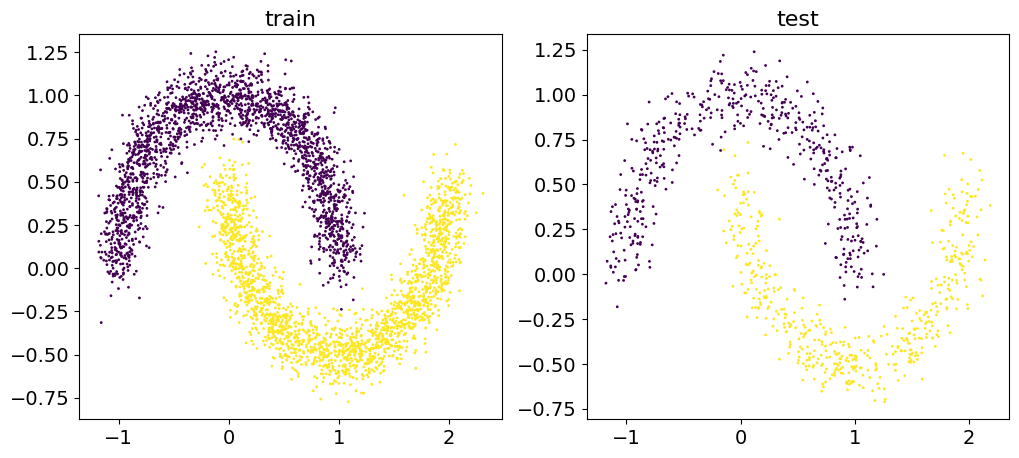

In [9]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Below you see the utility function, which broadcasts tensors. Look carefully at this code, we will use it in the majority of methods.

In [10]:
def _extract_into_tensor(arr, indices, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices to extract from arr.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    assert len(arr.shape) == 1
    res = arr.to(device=indices.device)[indices].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]


    return res.expand(broadcast_shape)

### Forward Diffusion

Let start with forward diffusion.

**Forward process** is defined as a posterior distribution $q(\mathbf{x}_{1:T}|\mathbf{x}_0)$.

It is a Markov chain, which consequently adds gaussian noise to a given object $\mathbf{x}_0$.

At every step of this process the gaussian noise is added with different magnitude, which is determined with a schedule of variances $\{\beta_1, ... \beta_T\}$.
If this schedule is chosen properly and T goes to infinity (or is large enough), we will converge to pure noise $\mathcal{N}(0, I)$.

Markov chain is defined by:
$$
 q(\mathbf{x}_t | \mathbf{x}_{t - 1}) := \mathcal{N}(\mathbf{x}_t | \sqrt{1 - \beta_t}x_{t - 1}, \beta_tI), \ \ \ \ \ \ \ q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t = 1}^T q(\mathbf{x}_t | \mathbf{x}_{t - 1})
$$

In order to get $\mathbf{x}_t$ we have to compute $\mathbf{x}_1, ..., \mathbf{x}_{t - 1}$ iteratively.

Hopefully, due to the properties of the gaussian distribution we can do it more efficiently.

Let's denote
$\alpha_t = 1- \beta_t$ и $\bar{\alpha}_t= \prod_{s = 1}^t\alpha_s$.
Then
$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t|\sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1-\bar{\alpha}_t) \mathbf{I}).
\tag{1}
$$

Here we could get very useful expression
$$
    \mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \cdot \boldsymbol{\epsilon}. \tag{2}
$$

Now we will create base class for diffusion (we will use it as a python base class for forward and backward diffusions).

In [15]:
class BaseDiffusion:
    def __init__(self, num_timesteps: int):
        self.num_timesteps = num_timesteps
        self.betas = self._get_beta_schedule(num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=-1)

    @staticmethod
    def _get_beta_schedule(num_diffusion_timesteps):
        assert num_diffusion_timesteps >= 20
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()
        betas = torch.from_numpy(betas).double()
        return betas


basediff = BaseDiffusion(num_timesteps=20)
basediff.betas,basediff.alphas_cumprod

(tensor([0.0050, 0.0574, 0.1097, 0.1621, 0.2145, 0.2668, 0.3192, 0.3716, 0.4239,
         0.4763, 0.5287, 0.5811, 0.6334, 0.6858, 0.7382, 0.7905, 0.8429, 0.8953,
         0.9476, 1.0000], dtype=torch.float64),
 tensor([9.9500e-01, 9.3792e-01, 8.3499e-01, 6.9964e-01, 5.4958e-01, 4.0293e-01,
         2.7431e-01, 1.7238e-01, 9.9302e-02, 5.2003e-02, 2.4510e-02, 1.0268e-02,
         3.7641e-03, 1.1827e-03, 3.0969e-04, 6.4872e-05, 1.0192e-05, 1.0674e-06,
         5.5900e-08, 0.0000e+00], dtype=torch.float64))

We are ready to define forward diffusion process. It has 2 methods:
- to get mean and variance of the distribution $q(\mathbf{x}_t | \mathbf{x}_0)$,
- to get samples from this distribution.

In [28]:
class ForwardDiffusion(BaseDiffusion):
    def get_mean_variance(self, x0, t):
        # ====
        # your code
        # calculate mean and variance of the distribution q(x_t | x_0) (use equation (1))
        alhpa_t = self.alphas_cumprod[t].unsqueeze(1)
        mean = x0 * alhpa_t.sqrt()
        variance = (1-alhpa_t) * torch.ones_like(x0)
        # ====
        return mean, variance

    def get_samples(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        # ====
        # your code
        # sample from the distribution q(x_t | x_0) (use equation (2))
        alhpa_t = self.alphas_cumprod[t].unsqueeze(1)
        samples = x0 *alhpa_t.sqrt() + noise * (1-alhpa_t).sqrt()
        # ====

        return samples


def test_forward_diffusion():
    fdiff = ForwardDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    x0 = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    mean, variance = fdiff.get_mean_variance(x0=x0, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9820154)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.03564582)

    xt = fdiff.get_samples(x0=x0, t=t)
    assert list(xt.shape) == SHAPE

    noise = torch.ones(SHAPE)
    xt = fdiff.get_samples(x0=x0, t=t, noise=noise)
    assert np.allclose(xt.numpy(), np.ones(SHAPE) * 1.1708164)


test_forward_diffusion()

Let visualize the forward diffusion process. Here you have to see how the distribution of the real samples transforms to the gaussian noise.

torch.Size([4000, 2])


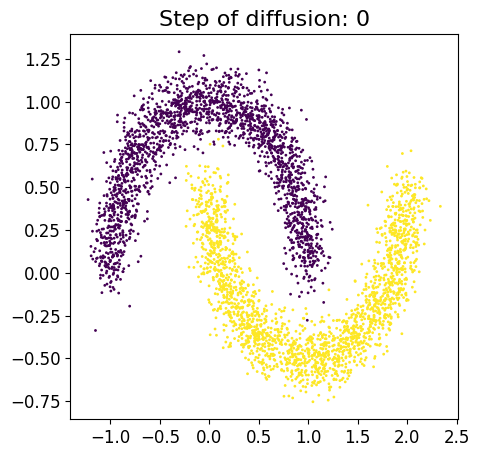

torch.Size([4000, 2])


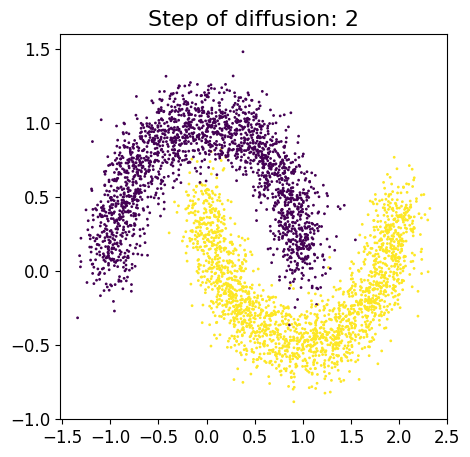

torch.Size([4000, 2])


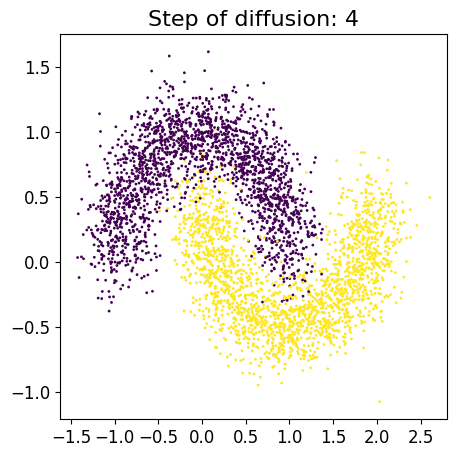

torch.Size([4000, 2])


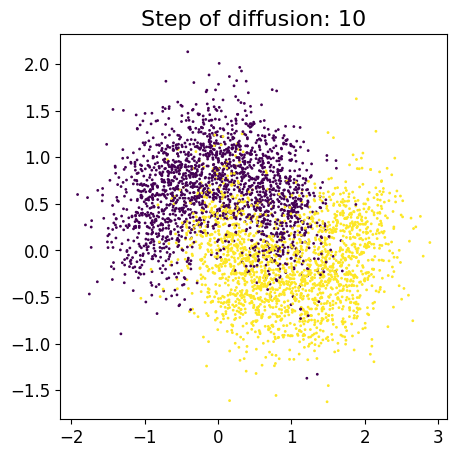

torch.Size([4000, 2])


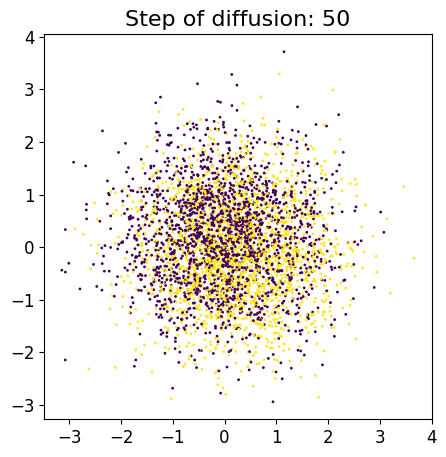

In [30]:
T = 100

fdiff = ForwardDiffusion(num_timesteps=T)

timestamps=[0, 2, 4, 10, 50]

plot_n_steps = len(timestamps)
for i, t in enumerate(timestamps):
    x = fdiff.get_samples(x0=torch.from_numpy(train_data), t=torch.ones((train_data.shape[0])).long() * t)
    print(x.shape)
    visualize_2d_samples(x, title=f"Step of diffusion: {t}", labels=train_labels)

### Reverse Diffusion

**Reverse process** consequently denoises pure gaussian noise $\mathcal{N}(0, \mathbf{I})$ until we do not get the object from the original distribution $\pi(\mathbf{x})$.

It is a probability model with latent variables
$p(\mathbf{x}_0 | \boldsymbol{\theta}) := \int p(\mathbf{x}_{0:T} | \boldsymbol{\theta}) d\mathbf{x}_{1:T}$,
where
- latents $\mathbf{z} = \{\mathbf{x}_1, ..., \mathbf{x}_T \}$ correspond to noised objects
- $\mathbf{x}_0$ is an object from the original distribution $\pi(\mathbf{x})$.

Joint distribution $p(\mathbf{x}_{0:T} | \boldsymbol{\theta})$ is called reverse diffusion process, which is essentially a Markov chain of gaussian distributions $p(\mathbf{x}_{i-1}|\mathbf{x}_{i}, \boldsymbol{\theta})$:
$$
p(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod_{t = 1}^T p(\mathbf{x}_{t-1}|\mathbf{x}_t, \boldsymbol{\theta}), \quad p(\mathbf{x}_{T} | \boldsymbol{\theta})=\mathcal{N}(\mathbf{x}_T | 0, \mathbf{I})
$$
$$
  p(\mathbf{x}_{t - 1}|\mathbf{x}_t | \boldsymbol{\theta}) = \mathcal{N}(\mathbf{x}_{t - 1}| \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_t, t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}}(\mathbf{x}_t, t)). \tag{3}
$$

In Lecture 12 we have derived ELBO for this model:

$$
    \mathcal{L}(q, \boldsymbol{\theta}) =  \mathbb{E}_{q} \Bigl[\log p(\mathbf{x}_0 | \mathbf{x}_1, \boldsymbol{\theta}) - KL\bigl(q(\mathbf{x}_T | \mathbf{x}_0) || p(\mathbf{x}_T)\bigr)
    - \sum_{t=2}^T \underbrace{KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)}_{\mathcal{L}_t} \Bigr].
$$

Here we use the following distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $, where
$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0
\tag{4}
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
\tag{5}
$$

(These scary formulas are not difficult to derive, follow the link to find details [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239)).

Now our goal is to define parameters $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_t, t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}}(\mathbf{x}_t, t)$ of reverse diffusion.

#### Variance
Our first assumption is to set the variance $\boldsymbol{\sigma}^2_{\boldsymbol{\theta}}(\mathbf{x}_t, t) = \tilde{\beta}_t$. This is very native assumption

#### Mean
Here we will use the expression (2) to get $\mathbf{x}_0$ from $\mathbf{x}_t$:
$$
    \mathbf{x}_0 = \frac{\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_{t}} \cdot \boldsymbol{\epsilon}}{\sqrt{\bar{\alpha}_{t}}}.
    \tag{6}
$$

If we put this expression to the formula (4) we will get:
$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon} \right).
$$

So the idea here to parametrize the model mean in the same functional form:
$$
    \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t) \right).
$$

**Note:** our model will predict the noise which was applied to $\mathbf{x}_0$ to get $\mathbf{x}_t$.

In [38]:
class ReverseDiffusion(BaseDiffusion):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=self.betas.device), self.alphas_cumprod[:-1]], dim=0
        )

        # ====
        # your code
        # calculate variance of the distribution q(x_{t-1} | x_t, x_0) mean (use equation (5))
        variance = (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * self.betas
        # ====
        # first value is zero, futher we will take log of this expression, so we will replace first value by the second value.
        self.variance_clipped = torch.cat([variance[1:2], variance[1:]], dim=0)

        # ====
        # your code
        # calculate coefficients of the distribution q(x_{t-1} | x_t, x_0) mean (use equation (4))
        self.xt_coef = self.alphas.sqrt() * (1-self.alphas_cumprod_prev) /(1 - self.alphas_cumprod)
        self.x0_coef = self.alphas_cumprod_prev.sqrt() * self.betas /(1 - self.alphas_cumprod)
        # ====

    def get_x0(self, xt, eps, t):
        # ====
        # your code
        # get x_0 (use equation (6))
        alpha_t = self.alphas_cumprod[t].unsqueeze(1)
        x0 = (xt -  (1-alpha_t).sqrt() * eps)/ alpha_t.sqrt()

        # ====
        return x0

    def get_mean_variance(self, xt, eps, t):
        # ====
        # your code
        # get mean and variance of the distribution q(x_{t-1} | x_t, x_0) mean (use equations (4) and (5))

        mean = self.xt_coef[t].unsqueeze(1) * xt + self.x0_coef[t].unsqueeze(1) * self.get_x0(xt, eps, t)
        variance = self.variance_clipped[t].unsqueeze(1) * np.ones_like(xt)

        # ====
        return mean, variance

    def get_samples(self, xt, eps, t):
        # read this code carefully
        mean, variance = self.get_mean_variance(xt=xt, eps=eps, t=t)
        noise = torch.randn_like(xt, device=xt.device)

        nonzero_mask = torch.ones_like(t)  # to not add any noise while predicting x0
        nonzero_mask[t == 0] = 0
        nonzero_mask = _extract_into_tensor(
            nonzero_mask, torch.arange(nonzero_mask.shape[0]), xt.shape
        )
        nonzero_mask = nonzero_mask.to(xt.device)
        sample = mean + nonzero_mask * variance.sqrt() * noise
        return sample.float()


def test_reverse_diffusion():
    rdiff = ReverseDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    xt = torch.ones(SHAPE)
    eps = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5

    x0 = rdiff.get_x0(xt=xt, eps=eps, t=t)
    assert list(x0.shape) == SHAPE
    assert np.allclose(x0.numpy(), np.ones(SHAPE) * 0.8260552)

    mean, variance = rdiff.get_mean_variance(xt=xt, eps=eps, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9467155)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.007709955)

    x = rdiff.get_samples(xt, eps, t)
    assert list(x.shape) == SHAPE


test_reverse_diffusion()

### Model

In this task we will use simple MLP model to parametrize distribution $p(\mathbf{x}_{t-1} | \mathbf{x}_t, \boldsymbol{\theta})$. It will be conditioned on the timestamps.

In [39]:
class ConditionalMLP(nn.Module):
    def __init__(self, input_dim: int, num_embeds: int, hidden_dim: int = 128):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.x_proj = nn.Linear(input_dim, self.hidden_dim)
        self.t_proj = nn.Embedding(num_embeds, self.hidden_dim)
        self.backbone = nn.Sequential(
            nn.Linear(self.hidden_dim, 2 * self.hidden_dim),
            nn.GELU(),
            nn.Linear(2 * self.hidden_dim, input_dim),
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x, t):
        x = self.x_proj(x)
        t = self.t_proj(t.int())
        x = x + t
        x = F.gelu(x)
        return self.backbone(x)


def test_conditional_mlp():
    SHAPE = [2, 20]
    T = 100
    x = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    model = ConditionalMLP(input_dim=20, num_embeds=100)
    output = model(x, t)
    assert list(output.shape) == SHAPE


test_conditional_mlp()

### DDPM

Let return to the ELBO. The main part of it is:
$$
    \mathcal{L}_t = KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)
$$

In Lecture 12 we have got that
$$
    \mathcal{L}_t = \mathbb{E}_{\boldsymbol{\epsilon}} \left[ \frac{\beta_t^2}{2 \tilde{\beta_t} \alpha_t (1 - \bar{\alpha}_t)} \| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t) \|^2 \right].
$$

In practice this loss is simplified. Particilarly, we will omit coefficient of the norm and we will sample index $t$ at each training step.

Finally, we will train our model with the following objective:
$$
\text{loss} = \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}, t}\bigg[ \|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t)\|^2\bigg],
$$
where $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$.

The following class implements two methods:
- `train_loss` - to compute the loss at the training step;
- `sample` - to sample from the final model.

In [ ]:
class DDPM(nn.Module):
    def __init__(self, num_timesteps: int, model: nn.Module):
        super().__init__()

        self.num_timesteps = num_timesteps

        self.forward_diffusion = ForwardDiffusion(num_timesteps=num_timesteps)
        self.reverse_diffusion = ReverseDiffusion(num_timesteps=num_timesteps)
        self.model = model
        self.shape = None

    @property
    def device(self):
        return next(self.parameters()).device

    def sample(self, num_samples):
        assert self.shape is not None
        x = torch.randn((num_samples, *self.shape), device=self.device, dtype=torch.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = torch.tensor([i] * num_samples, device=x.device)
            with torch.no_grad():
                # ====
                # your code
                # 1) get epsilon from the model
                # 2) sample from the reverse diffusion

                # ====
        return x

    def train_loss(self, x0):
        if self.shape is None:
            self.shape = list(x0.shape)[1:]
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0)

        # ====
        # your code
        # 1) get x_t
        # 2) get epsilon from the model

        # ====
        loss = F.mse_loss(eps, noise)
        return loss

### Training

Now we are ready to train our model.

In [ ]:
def train_model(
    ddpm: DDPM,
    dataloader,
    lr: float,
    weight_decay: float,
    steps: int,
    use_cuda: bool,
    log_every: int = 500
):

    def _anneal_lr(step: int):
        frac_done = step / steps
        current_lr = lr * (1 - frac_done)
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr

    if USE_CUDA:
        ddpm = ddpm.cuda()
    optimizer = torch.optim.AdamW(
        ddpm.model.parameters(), lr=lr, weight_decay=weight_decay
    )
    step = 0
    curr_loss_gauss = 0.0
    curr_count = 0
    optimizer.zero_grad()
    data_iter = iter(dataloader)
    while step < steps:
        try:
            x = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            x = next(data_iter)

        if USE_CUDA:
            x = x.cuda()

        loss = ddpm.train_loss(x)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _anneal_lr(step)

        curr_count += len(x)
        curr_loss_gauss += loss.item() * len(x)

        if (step + 1) % log_every == 0:
            gloss = np.around(curr_loss_gauss / curr_count, 4)
            print(f"Step {(step + 1)}/{steps} Loss: {gloss}")
            curr_count = 0
            curr_loss_gauss = 0.0

        step += 1

In [ ]:
T = 100
# ====
# your code
# choose these parameters
BATCH_SIZE =
LR =
WEIGHT_DECAY =
STEPS =
# ====

model = ConditionalMLP(input_dim=2, num_embeds=T)
ddpm = DDPM(num_timesteps=T, model=model)

dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    steps=STEPS,
    use_cuda=USE_CUDA
)

Now let's sample from our trained model.

In [ ]:
samples = ddpm.sample(num_samples=5000).cpu()

visualize_2d_samples(samples, title="Samples")

Now let's see how denoising looks like (similarly to forward noising process).

In [ ]:
timestamps=[0, 2, 4, 10, 50]

x = torch.randn(train_data.shape[0], 2, requires_grad=False).to(ddpm.device)
for i in range(ddpm.num_timesteps - 1, -1, -1):
    t = torch.tensor(i, dtype=torch.long, requires_grad=False).expand(x.shape[0]).to(ddpm.device)
    with torch.no_grad():
        eps = ddpm.model(x, t)
        x = ddpm.reverse_diffusion.get_samples(xt=x, eps=eps, t=t)
    if i in reversed(timestamps):
        x_ = x.cpu()
        visualize_2d_samples(x_, title=f"Samples from timestamp: {i}")

## Task3: DDPM on MNIST (4pt)

Let apply our diffusion model to the MNIST dataset.

100%|██████████| 9912422/9912422 [00:00<00:00, 73795483.50it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32721689.31it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23696732.56it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14069814.45it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



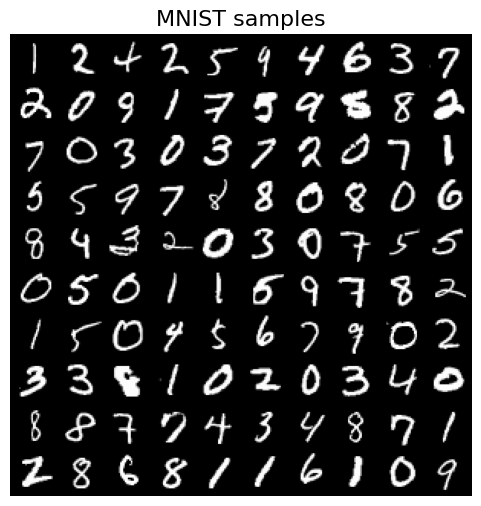

In [5]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)

visualize_images(train_data, "MNIST samples")

DATA_MEAN = train_data.mean()
DATA_STD = train_data.std()

train_data = (train_data - DATA_MEAN) / DATA_STD

Let's take a look at the forward process for the MNIST images.

In [ ]:
T = 1000

fdiff = ForwardDiffusion(num_timesteps=T)

timestamps=[0, 50, 100, 200, 300, 500, 600, 800, 999]

plot_n_steps = len(timestamps)
samples = []
x0 = train_data[10:11]
for i, t in enumerate(timestamps):
    x = fdiff.get_samples(x0=torch.from_numpy(x0), t=torch.ones((x0.shape[0], 1)).long() * t)
    samples.append(x.cpu().numpy())

samples = np.concatenate(samples)
samples = samples * DATA_STD + DATA_MEAN
show_samples(samples, title="Noisy samples")

The model is written for you. We will use UNet architecture.

In [ ]:
from unet import MyUNet

In this task you just have to train the model. All previous parts of the pipeline will be the same.

In [ ]:
T = 1000
# ====
# your code
# choose these parameters
BATCH_SIZE =
LR =
WEIGHT_DECAY =
STEPS =
# ====

dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

model_mnist = MyUNet(n_steps=T)
ddpm_mnist = DDPM(num_timesteps=T, model=model_mnist)

train_model(
    ddpm=ddpm_mnist,
    dataloader=dataloader,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    steps=STEPS,
    use_cuda=USE_CUDA,
    log_every=200
)

Let's draw samples from the trained model.

In [ ]:
if USE_CUDA:
    ddpm_mnist = ddpm_mnist.cuda()

with torch.no_grad():
    samples = ddpm_mnist.sample(num_samples=25).cpu().numpy()

samples = samples * DATA_STD + DATA_MEAN

show_samples(samples, title="Samples")

In [ ]:
train_data


torch.randn